<left><img width=25% src="img/gw_monogram_2c.png"></left>

# Lecture 10: Clustering

__Sardar Hamidian__<br>The George Washington Universiry

__Armin Mehrabian__<br>The George Washington Universiry

# Review: Unsupervised Learning

We have a dataset *without* labels. Our goal is to learn something interesting about the structure of the data:
* Clusters hidden in the dataset.
* Outliers: particularly unusual and/or interesting datapoints.
* Useful signal hidden in noise, e.g. human speech over a noisy phone.

# Clustering

Clustering is the problem of identifying distinct components in the data.
<!-- * A cluster $C_k \subseteq \mathcal{X}$ can be thought of as a subset of the space $\mathcal{X}$. -->
<!-- * Datapoints in a cluster are more similar to each other than to points in other clusters -->
<center><img width=60% src="img/gda_example.png"></center>
<!-- * Clusters are usually defined by their centers, and potentially by other shape parameters. -->
Applications: customer segmentation, topic discovery, biological analysis

# Review: $K$-Means

$K$-Means is the simplest example of a clustering algorithm.
Starting from random centroids, we repeat until convergence:

1. Update each cluster: assign each point to its closest centroid.
2. Set each centroid to be the center of the its cluster.

This is best illustrated visually (from [Wikipedia](https://commons.wikimedia.org/wiki/File:K-means_convergence.gif)):

<center><img width=50% src="img/kmeans_convergence.gif"></center>

$K$-Means has a number of limitations:

* Clustering can get stuck in local minima
* Measuring clustering quality is hard and relies on heuristics
* Cluster assignment is binary and doesn't estimate confidence

We will address the latter two points in this lecture.

# Part 1: Gaussian Mixture Models for Clustering

Clustering is a common unsupervised learning problem with numerous applications.

We will start by defining the problem and outlining some models for this problem.

# GMMs: A Type of Generative Model

Gaussian mixtures form a generative model $P_\theta(x,z)$. For example, when $z \in \{0,1\}$, we define (using Gaussians):

\begin{align*}
P_\theta(x|z=\text{0}) && P_\theta(x|z=\text{1})
\end{align*}

We also define priors $P_\theta(z=\text{0}), P_\theta(z=\text{1})$

# Review: Normal (Gaussian) Distribution

A [multivariate normal](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) distribution with parameters $\theta = (\mu, \Sigma)$
is a probability over a $d$-dimensional $x \in \mathbb{R}^d$

$$
\mathcal{N}(x; \mu, \Sigma) = \frac{1}{\sqrt{(2 \pi)^d | \Sigma |}} \exp\left(-\frac{1}{2} (x - \mu)^\top \Sigma^{-1} (x-\mu) \right)
$$

In one dimension, this reduces to $\frac{1}{\sqrt{2 \pi}\sigma} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2} \right)$.

This what the density of a Normal distribution looks like in 2D:

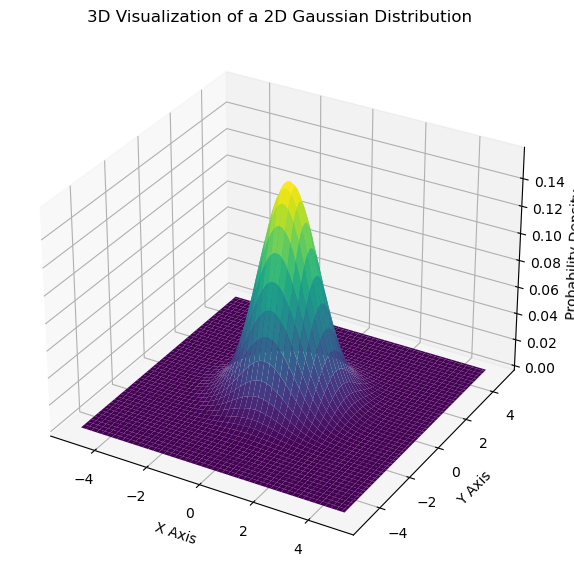

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

# Mean and Covariance matrix for the 2D Gaussian
mean = np.array([0, 0])
cov_matrix = np.array([[1, 0], [0, 1]])

# Create a grid of (x, y) values
x, y = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.dstack((x, y))

# Create a 2D Gaussian Distribution with the given mean and covariance
rv = multivariate_normal(mean, cov_matrix)

# Compute the values of the Gaussian at each grid point
z = rv.pdf(pos)

# Set up the plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, y, z, cmap='viridis', linewidth=0)

# Set labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Probability Density')

plt.title('3D Visualization of a 2D Gaussian Distribution')

# Show the plot
plt.show()


This is how we can visualize it in a 2D plane:


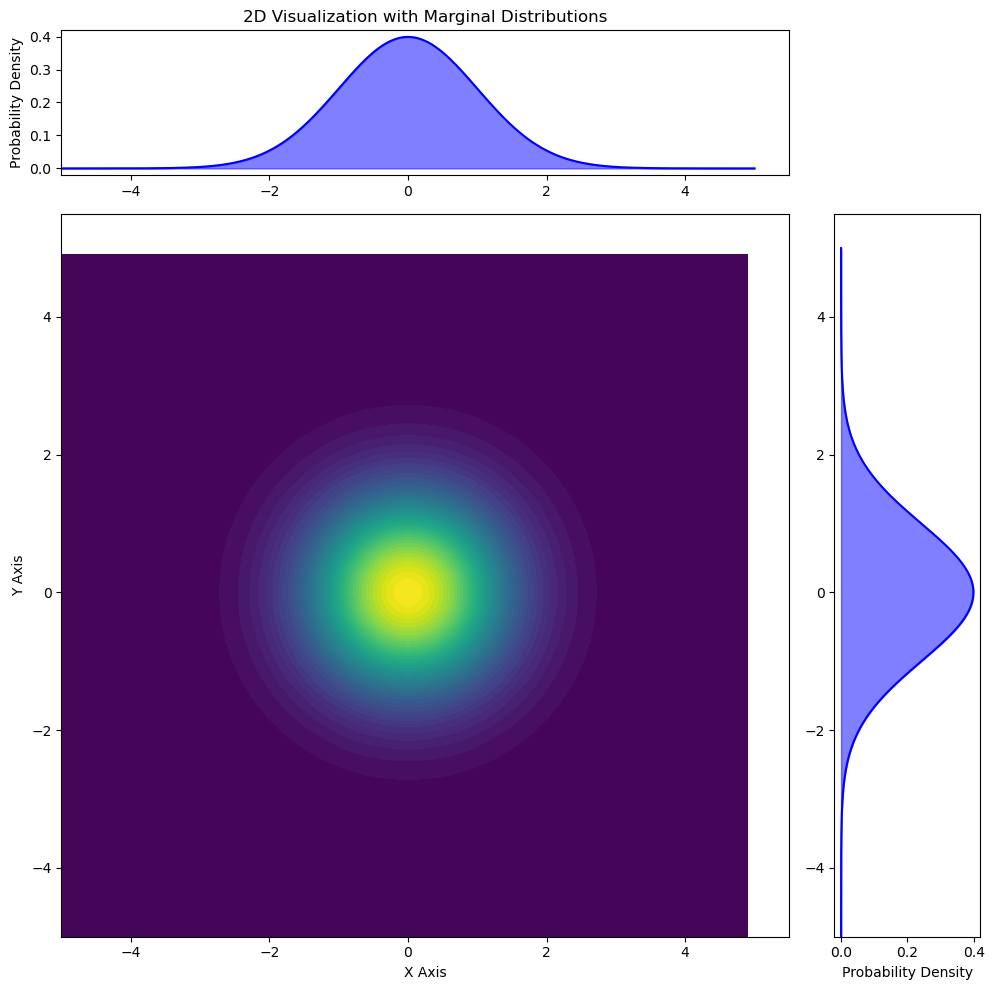

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
import matplotlib.gridspec as gridspec

# Mean and Covariance matrix for the 2D Gaussian
mean = np.array([0, 0])
cov_matrix = np.array([[1, 0], [0, 1]])

# Create a grid of (x, y) values
x, y = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.dstack((x, y))

# Create a 2D Gaussian Distribution with the given mean and covariance
rv = multivariate_normal(mean, cov_matrix)

# Compute the values of the Gaussian at each grid point
z = rv.pdf(pos)

# Set up the figure and gridspec
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1, 5])
ax_main = fig.add_subplot(gs[1, 0])
ax_xDist = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_yDist = fig.add_subplot(gs[1, 1], sharey=ax_main)

# Main 2D Gaussian contour plot
ax_main.contourf(x, y, z, cmap='viridis', levels=50)
ax_main.set_xlabel('X Axis')
ax_main.set_ylabel('Y Axis')

# Marginal X Distribution
x_vals = np.linspace(-5, 5, 400)
ax_xDist.plot(x_vals, norm.pdf(x_vals, mean[0], np.sqrt(cov_matrix[0,0])), color='blue')
ax_xDist.fill_between(x_vals, norm.pdf(x_vals, mean[0], np.sqrt(cov_matrix[0,0])), alpha=0.5, color='blue')
ax_xDist.set_ylabel('Probability Density')
ax_xDist.set_title('2D Visualization with Marginal Distributions')

# Marginal Y Distribution
y_vals = np.linspace(-5, 5, 400)
ax_yDist.plot(norm.pdf(y_vals, mean[1], np.sqrt(cov_matrix[1,1])), y_vals, color='blue')
ax_yDist.fill_betweenx(y_vals, norm.pdf(y_vals, mean[1], np.sqrt(cov_matrix[1,1])), alpha=0.5, color='blue')
ax_yDist.set_xlabel('Probability Density')

# Adjust the space between the plots
plt.tight_layout()

# Show the plots
plt.show()


# Gaussian Mixture Models: An Example

GMMs are a probabilistic generative models $P_\theta(x,z)=P_\theta(x|z) P_\theta(z)$ that can be used for clustering.

\begin{align*}
P_\theta(x|y=\text{0}) = \mathcal{N}(x; \mu_0, \Sigma_0) && P_\theta(x|y=\text{1}) = \mathcal{N}(x; \mu_1, \Sigma_1) && \text{etc.}
\end{align*}

We also define $P_\theta(y=\text{0}) = \phi_0$, $P_\theta(y=\text{1}) = \phi_1$, etc.

The data probability is then written as:

\begin{align*}
P_\theta(x) & = P_\theta(x | z=0) \cdot P_\theta(z=0) + P_\theta(x | z=1) \cdot P_\theta(z=1)\\
& = \mathcal{N}(x; \mu_0, \Sigma_0) \cdot \phi_0 + \mathcal{N}(x; \mu_1, \Sigma_1) \cdot \phi_1
\end{align*}


Here is an example of one Gaussian and a mixture of two Gaussians:

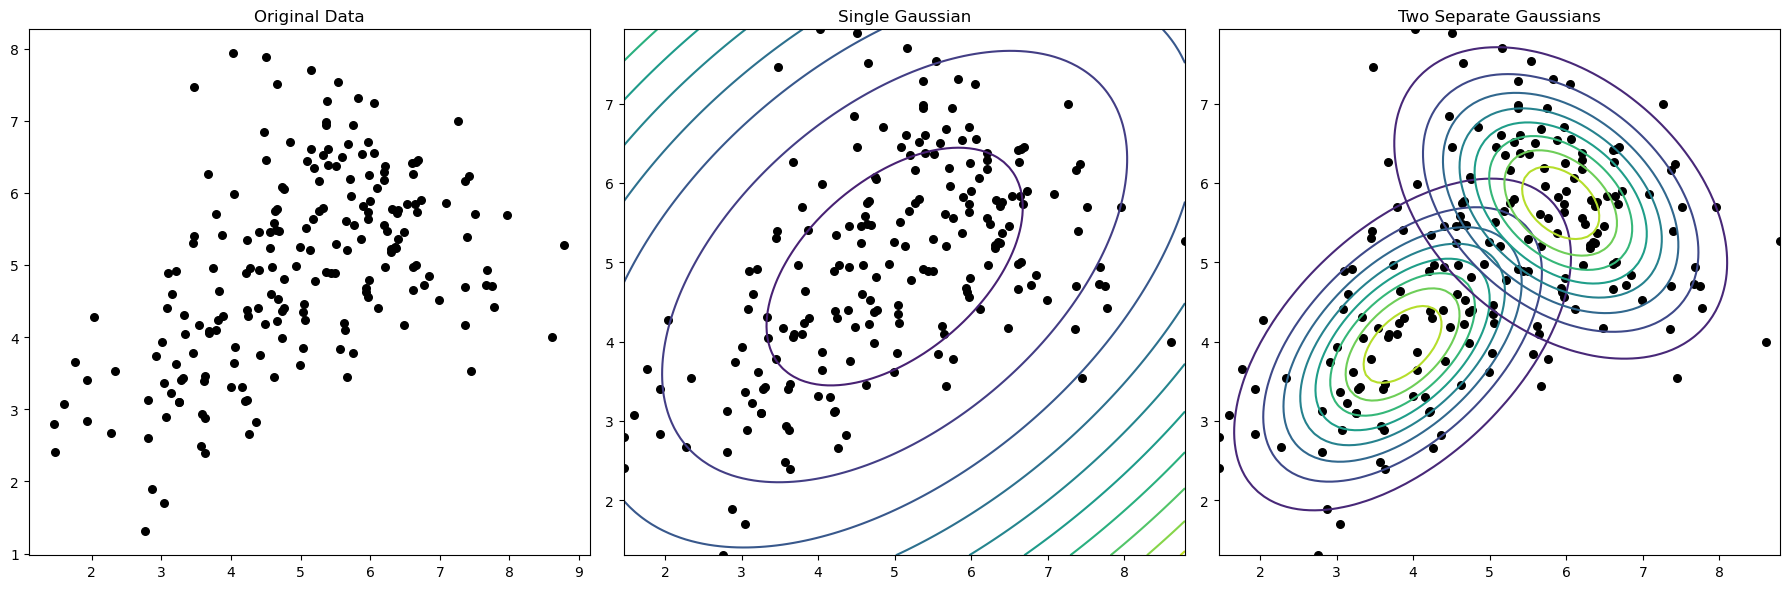

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

# Generate synthetic data
np.random.seed(0)
mean_one, cov_one = [4, 4], [[1, 0.5], [0.5, 1]]
mean_two, cov_two = [6, 6], [[1, -0.5], [-0.5, 1]]
data_one = np.random.multivariate_normal(mean_one, cov_one, 100)
data_two = np.random.multivariate_normal(mean_two, cov_two, 100)

# Combine the data
data_combined = np.concatenate([data_one, data_two])

# Set the figure size
plt.figure(figsize=(18, 6))  # This creates a figure with width 18 and height 6

# Plot the original data without any Gaussian
plt.subplot(1, 3, 1)
plt.scatter(data_combined[:, 0], data_combined[:, 1], c='black', s=30, edgecolor='k')
plt.title('Original Data')

# Fit a single Gaussian to the data
gmm_single = GaussianMixture(n_components=1, covariance_type='full').fit(data_combined)

a = np.linspace(np.min(data_combined[:, 0]), np.max(data_combined[:, 0]), num=100)
b = np.linspace(np.min(data_combined[:, 1]), np.max(data_combined[:, 1]), num=100)
A, B = np.meshgrid(a, b)
AB = np.array([A.ravel(), B.ravel()]).T
Z_single = -gmm_single.score_samples(AB)
Z_single = Z_single.reshape(A.shape)

# Plot the data with single Gaussian contour
plt.subplot(1, 3, 2)
plt.scatter(data_combined[:, 0], data_combined[:, 1], c='black', s=30, edgecolor='k')
plt.contour(A, B, Z_single, levels=10)
plt.title('Single Gaussian')

# Fit two Gaussians to the data
gmm_double = GaussianMixture(n_components=2, covariance_type='full').fit(data_combined)

# Plot the data with contours for each Gaussian separately
plt.subplot(1, 3, 3)
plt.scatter(data_combined[:, 0], data_combined[:, 1], c='black', s=30, edgecolor='k')

for i in range(gmm_double.n_components):
    Z_double = multivariate_normal.pdf(AB, mean=gmm_double.means_[i], cov=gmm_double.covariances_[i])
    Z_double = Z_double.reshape(A.shape)
    plt.contour(A, B, Z_double, levels=np.linspace(Z_double.min(), Z_double.max(), 10))

plt.title('Two Separate Gaussians')
plt.tight_layout()
plt.show()


GMMs are a probabilistic model that can be used for clustering.
$$P_\theta (x,z) = P_\theta (x | z) P_\theta (z)$$
* This model postulates that our observed data is comprised of  $K$ clusters with proportions specified by $\phi_1,\phi_2, \ldots, \phi_K$
* The points within each cluster follow a Normal distribution $P_\theta(x | z=k) = \mathcal{N}(\mu_k, \Sigma_k)$.
* $z^{(i)}$ is the cluster label for data point $x^{(i)}$ and can be obtained from $P(z^{(i)}|x^{(i)})$

# Gaussian Mixture Models for Clustering

To cluster using GMMs: (1) fit the GMM model to the data; (2) use the mean of each centroid as the Gaussian.

<center><img width=60% src="img/gda_example.png"></center>

# Warm-Up: Clustering With Known Cluster Assignments

Suppose we have a dataset $\mathcal{D} = \{(x^{(1)}, z^{(1)}), (x^{(2)}, z^{(2)}), \ldots, (x^{(n)}, z^{(n)})\}$, where the identity of each cluster is known.

* $x^{(i)} \in \mathbb{R}$ are the datapoints we cluster
* $z^{(i)} \in \{1,2,...,K\}$ are the cluster IDs
* We will fit a GMM, the $\mu_k$ will represent the cluster centroids.

How would we do this?

This is the same problem as in Gaussian Distriminant Analysis (GDA). We can fit a GMM to this data as follows:

1. We fit the parameters $\phi_k$ to be % of each class $k$ in $\mathcal{D}$.
2. We fit the parameters $\mu_k, \Sigma_k$ to be means and variances of each class $k$.
3. We can infer the cluster ID $z$ of new points using $P(z|x)$ as in GDA.

Let's look at an example on our Iris flower dataset.

In [4]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris(as_frame=True)

# print part of the dataset
iris_X, iris_y = iris.data, iris.target
pd.concat([iris_X, iris_y], axis=1).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Recall that we have previously seen how to fit GMMs on a labeled $(x,y)$ dataset using using maximum likelihood.

Let's try this on our Iris dataset again (recall that this is called GDA).

In [5]:
# we can implement these formulas over the Iris dataset
X = iris_X.to_numpy()[:,:2]
d = 2 # number of features in our toy dataset
K = 3 # number of clases
n = X.shape[0] # size of the dataset

# these are the shapes of the parameters
mus = np.zeros([K,d])
Sigmas = np.zeros([K,d,d])
phis = np.zeros([K])

# we now compute the parameters
for k in range(3):
    X_k = X[iris_y == k]
    mus[k] = np.mean(X_k, axis=0)
    Sigmas[k] = np.cov(X_k.T)
    phis[k] = X_k.shape[0] / float(n)

This code lets us generate predictions from the GMM model that we just learned by implementing Bayes' rule.

In [6]:
# we can implement this in numpy
def gda_predictions(x, mus, Sigmas, phis):
    """This returns class assignments and p(y|x) under the GDA model.
    
    We compute \arg\max_y p(y|x) as \arg\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x, (1, n, d, 1))
    mus = np.reshape(mus, (K, 1, d, 1))
    Sigmas = np.reshape(Sigmas, (K, 1, d, d))    
    
    # compute probabilities
    py = np.tile(phis.reshape((K,1)), (1,n)).reshape([K,n,1,1])
    pxy = (
        np.sqrt(np.abs((2*np.pi)**d*np.linalg.det(Sigmas))).reshape((K,1,1,1)) 
        * -.5*np.exp(
            np.matmul(np.matmul((x-mus).transpose([0,1,3,2]), np.linalg.inv(Sigmas)), x-mus)
        )
    )
    pyx = pxy * py
    return pyx.argmax(axis=0).flatten(), pyx.reshape([K,n])

idx, pyx = gda_predictions(X, mus, Sigmas, phis)

We can visualize the GMM as follows:

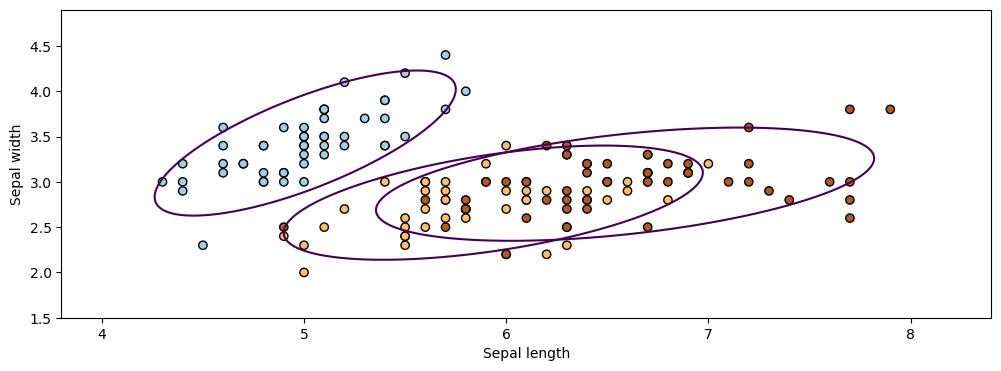

In [7]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [12, 4]

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z, pyx = gda_predictions(np.c_[xx.ravel(), yy.ravel()], mus, Sigmas, phis)
logpy = np.log(-1./3*pyx)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
contours = np.zeros([K, xx.shape[0], xx.shape[1]])
for k in range(K):
    contours[k] = logpy[k].reshape(xx.shape)
for k in range(K):
    plt.contour(xx, yy, contours[k], levels=np.logspace(0, 1, 1))

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=iris_y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

In the above example, the $P_\theta(z|x)$ from the GMM $P_\theta$ tells us the cluster ID $z$ of $x$.

But what if we don't have labels to train $P_\theta$?

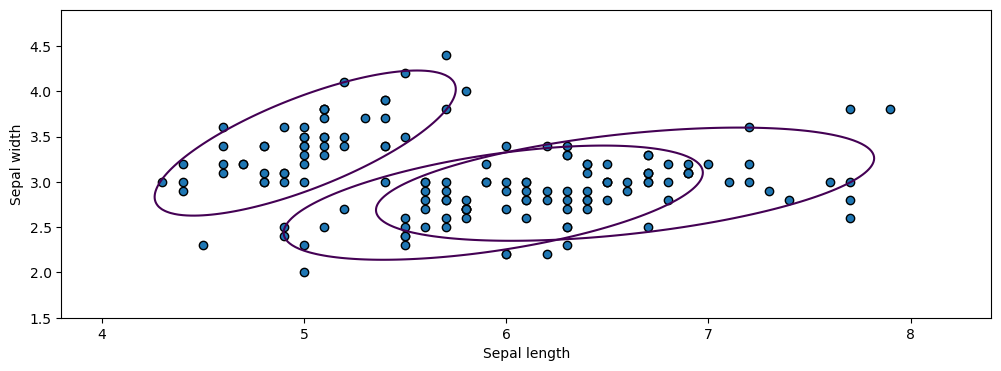

In [8]:
for k in range(K):
    plt.contour(xx, yy, contours[k], levels=np.logspace(0, 1, 1))

plt.scatter(X[:, 0], X[:, 1], edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

# From Labeled to Unlabeled Clustering

Next, we want to train a GMM clustering model from unlabeled data.

Our strategy will be to jointly learn cluster parameters and labels:

1. We will define an objective that does not require cluster labels $z^{(i)}$.
2. We will define an optimizer that jointly infers both labels $z^{(i)}$ and cluster parameters $\mu_k, \Sigma_k$.

# Objective: Marginal Likelihood

Maximum marginal (log-)likelihood is a way of learning any proabilistic model on an unsupervised dataset $\mathcal{D}$ by maximizing:
$$
\frac{1}{n}\sum_{i=1}^n \log P_\theta({x}^{(i)}) = \frac{1}{n}\sum_{i=1}^n \log \left(\sum_{z \in \mathcal{Z}} P_\theta({x}^{(i)}, z)\right).
$$

* This asks $P_\theta$ to assign a high probability to the training data in $\mathcal{D}$. 
* However, we need to use $P(x) = \sum_{z \in \mathcal{Z}} P(x,z)$ to compute this probability because $z$ is not observed.

# Interpretations of Marginal Likelihood

Recall that our objective is:
$$\max_\theta \frac{1}{n}\sum_{i=1}^n \log \left(\sum_{z \in \mathcal{Z}} P_\theta({x}^{(i)}, z)\right)$$

* Our intuition of assigning high probability to data still holds

* $z$ encodes the cluster id; we ask $P_\theta$ to be high for *at least one $z$*

* We are  still minimizing KL divergence between $P_\theta(x)$ and $P_\text{data}(x)$

The Kullback-Leibler (KL) divergence $D(\cdot\|\cdot)$ between the model distribution and the data distribution is:
$$
D(P_\text{data} \| P_\theta) = \sum_{{\bf x}} P_\text{data}({\bf x}) \log \frac{P_\text{data}({\bf x})}{P_\theta({\bf x})}.
$$

The KL divergence is always non-negative, and equals zero when $P_\text{data}$ and $P_\theta$ are identical. This makes it a natural measure of similarity that's useful for comparing distributions. 

# Optimizing Marginal Likelihood

How do we optimize the marginal likelihood objective?
$$\max_\theta \frac{1}{n}\sum_{i=1}^n \log \left(\sum_{z \in \mathcal{Z}} P_\theta({x}^{(i)}, z)\right)$$

* Note that we can't flip the sum and the log!
* Because of that, our closed-form solutions don't apply
* In fact, the objective now has many local minima!

Optimizing the likelihood of mixture models is hard. 

A Gaussian has a single maximum, but a mixture has many and its objective is non-convex (hard to optimize).

<center><img width=50% src="img/mogdensity1d_v2.png"></center>

# Recovering Clusters from GMMs

Given a trained GMM model $P_\theta (x,z) = P_\theta (x | z) P_\theta (z)$, it's easy to compute the *posterior* probability

$$P_\theta(z = k\mid x) = \frac{P_\theta(z=k, x)}{P_\theta(x)} = \frac{P_\theta(x | z=k) P_\theta(z=k)}{\sum_{l=1}^K P_\theta(x | z=l) P_\theta(z=l)}$$

of a point $x$ belonging to class $k$.

* The posterior defines a "soft" assignment of $x$ to each class.
* This is in contrast to the hard assignments from $K$-Means.

# Beyond Gaussian Mixtures

We will focus on Gaussian mixture models in this lecture, but there exist many other kinds of clustering:
* Hierarchical clusters
* Points belonging to multiple clusters (e.g. topics)
* Clusters in graphs


See the `scikit-learn` [guide](https://scikit-learn.org/stable/modules/clustering.html) for more!

<left><img width=25% src="img/gw_monogram_2c.png"></left>
# Part 2: Expectation Maximization

We will now describe expecation maximization (EM), an algorithm that can be used to fit Gaussian mixture models.

# Review: Gaussian Mixture Models

Gaussian mixtures are latent-variable probabilistic models that are useful for clustering. They define a model
$$P_\theta (x,z) = P_\theta (x | z) P_\theta (z)$$
* $z \in \{1,2,\ldots,K\}$ is discrete and follows a categorical distribution $P_\theta(z=k) = \phi_k$.
* $x \in \mathbb{R}$ is continuous; conditioned on $z=k$, it follows a Normal distribution $P_\theta(x | z=k) = \mathcal{N}(\mu_k, \Sigma_k)$.

The parameters $\theta$ are the $\mu_k, \Sigma_k, \phi_k$ for all $k=1,2,\ldots,K$.

# Review: Learning GMMs

Gaussian mixtures are latent variable models, and we can learn them using maximum marginal log-likelihood:
$$
\max_\theta \sum_{x\in \mathcal{D}} \log P_\theta(x) = \max_\theta \sum_{x\in \mathcal{D}} \log \left( \sum_{z \in \mathcal{Z}}P_\theta(x, z) \right)
$$

* Unlike in supervised learning, cluster assignments are latent.
* Hence, there is not a closed form solution for $\theta$. 
<!-- * We will see specialized algorithm for this task. -->

# Expectation Maximization: Intuition

Expecation maximization (EM) is an algorithm for maximizing marginal log-likelihood 
$$\max_\theta \sum_{x^{(i)}\in \mathcal{D}} \log \left( \sum_{z \in \mathcal{Z}}P_\theta(x^{(i)}, z) \right)$$
that can also be used to learn Gaussian mixtures.

We want to optimize the marginal log-likelihood
$$\max_\theta \sum_{x^{(i)}\in \mathcal{D}} \log \left( \sum_{z \in \mathcal{Z}}P_\theta(x^{(i)}, z) \right).$$
* If we know the true $z^{(i)}$ for each $x^{(i)}$, we maximize
$$\max_\theta \sum_{x^{(i)}, z^{(i)}\in \mathcal{D}} \log \left( P_\theta(x^{(i)}, z^{(i)}) \right).$$
and it's easy to find the best $\theta$ (use solution for supervised learning).
* If we know $\theta$, we can estimate the cluster assignments $z^{(i)}$ for each $i$ by computing $P_\theta(z | x^{(i)})$.

Expectation maximization alternates between these two steps.

1. (__E-Step__) Given an estimate $\theta_t$ of the weights, compute $P_\theta(z | x^{(i)})$.
and use it to “hallucinate” expected cluster assignments $z^{(i)}_t$.
2. (__M-Step__) Find a new $\theta_{t+1}$ that maximizes the log-likelihood by optimizing $\max_\theta P_\theta(x^{(i)}, z^{(i)}_t)$ given the $z^{(i)}_t$ from step 1.

This process increases the marginal likelihood at each step and eventually converges.

# E-Step: Definition

Intuitively, we hallucinate $z^{(i)}$ in the E-Step. 

In practice, the $P_{\theta_t}(z|x^{(i)})$ define "soft" assignments, and we compute a vector of class probabilities for each $x^{(i)}$.
<!-- * The $P_{\theta_t}(z|x^{(i)})$ define "soft" assignments, and we compute a vector of class probabilities for each $x^{(i)}$.
* We compute an expected values over $z^{(i)}$ instead of hallucinating one value. -->

# M-Step: Definition

Since class assignments from E-step are probabilistic, we maximize an expectation:
\begin{align*}
\theta_{t+1} & = \arg\max_{\theta} \sum_{i=1}^n \mathbb{E}_{z^{(i)} \sim P_{\theta_t}(z|x^{(i)})} \log P_{\theta}(x^{(i)}, z^{(i)}) \\
& = \arg\max_{\theta} \sum_{i=1}^n \sum_{k=1}^K P_{\theta_t}(z=k|x^{(i)}) \log P_{\theta}(x^{(i)}, z=k)
\end{align*}
For many interesting models, this is tractable.

# Expectation Maximization: Definition

Formally, EM learns the parameters $\theta$ of a latent-variable model $P_\theta(x,z)$ over a dataset $\mathcal{D} = \{x^{(i)} \mid i = 1,2,...,n\}$ as follows.

For $t=0,1,2,\ldots$, repeat until convergence:
1. (__E-Step__) For each $x^{(i)} \in \mathcal{D}$ compute $P_{\theta_t}(z|x^{(i)})$
2. (__M-Step__) Compute new weights $\theta_{t+1}$ as
\begin{align*}
\theta_{t+1} & = \arg\max_{\theta} \sum_{i=1}^n \mathbb{E}_{z^{(i)} \sim P_{\theta_t}(z|x^{(i)})} \log P_{\theta}(x^{(i)}, z^{(i)})
\end{align*}

Since assignments $P_{\theta_t}(z|x^{(i)})$ are "soft", M-step involves an expectation.

# Pros and Cons of EM

EM is a very important optimization algorithm in machine learning.
* It is easy to implement and is guaranteed to converge.
* It works in a lot of imporant ML models.

Its limitations include:
* It can get stuck in local optima.
* We may not be able to compute $P_{\theta_t}(z|x^{(i)})$ in every model.

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 3: Expectation Maximization in Gaussian Mixture Models

Next, let's work through how Expectation Maximization works in Gaussian Mixture Models.

# Review: Gaussian Mixture Models

Gaussian mixtures define a model of the form:
$$P_\theta (x,z) = P_\theta (x | z) P_\theta (z)$$
* $z \in \mathcal{Z} = \{1,2,\ldots,K\}$ is discrete and follows a categorical distribution $P_\theta(z=k) = \phi_k$.
* $x \in \mathbb{R}$ is continuous; conditioned on $z=k$, it follows a Normal distribution $P_\theta(x | z=k) = \mathcal{N}(\mu_k, \Sigma_k)$.

The parameters $\theta$ are the $\mu_k, \Sigma_k, \phi_k$ for all $k=1,2,\ldots,K$.

# Review: Expectation Maximization

Formally, EM learns the parameters $\theta$ of a latent-variable model $P_\theta(x,z)$ over a dataset $\mathcal{D} = \{x^{(i)} \mid i = 1,2,...,n\}$ as follows.

For $t=0,1,2,\ldots$, repeat until convergence:
1. (__E-Step__) For each $x^{(i)} \in \mathcal{D}$ compute $P_{\theta_t}(z|x^{(i)})$
2. (__M-Step__) Compute new weights $\theta_{t+1}$ as
\begin{align*}
\theta_{t+1} & = \arg\max_{\theta} \sum_{i=1}^n \mathbb{E}_{z^{(i)} \sim P_{\theta_t}(z|x^{(i)})} \log P_{\theta}(x^{(i)}, z^{(i)})
\end{align*}

Since assignments $P_{\theta_t}(z|x^{(i)})$ are "soft", M-step involves an expectation.

# Deriving the E-Step

In the E-step, we compute the posterior for each data point $x$ as follows
 $$P_\theta(z = k\mid x) = \frac{P_\theta(z=k, x)}{P_\theta(x)} = \frac{P_\theta(x | z=k) P_\theta(z=k)}{\sum_{l=1}^K P_\theta(x | z=l) P_\theta(z=l)}$$
$P_\theta(z\mid x)$ defines a vector of probabilities that $x$ originates from component $k$ given the current set of parameters $\theta$

# Deriving the M-Step

At the M-step, we optimize the expected log-likelihood of our model.

\begin{align*}
&\max_\theta \sum_{x \in D} \mathbb{E}_{z \sim P_{\theta_t}(z|x)} \log P_\theta(x,z) = \\
& \max_\theta \left( \sum_{k=1}^K \sum_{x \in D} P_{\theta_t}(z_k|x) \log P_\theta(x|z_k) + \sum_{k=1}^K \sum_{x \in D} P_{\theta_t}(z_k|x) \log P_\theta(z_k) \right)
\end{align*}

As in supervised learning, we can optimize the two terms above separately.

We will start with $P_\theta(x\mid z=k) = \mathcal{N}(x; \mu_k, \Sigma_k)$. We have to find $\mu_k, \Sigma_k$ that optimize
$$
\max_\theta \sum_{x^{(i)} \in D} P(z=k|x^{(i)}) \log P_\theta(x^{(i)}|z=k)
$$
Note that this corresponds to fitting a Gaussian to a dataset whose elements $x^{(i)}$ each have a weight $P(z=k|x^{(i)})$.

Similarly to how we did this in the supervised regime, we compute the derivative, set it to zero, and obtain closed form solutions:
\begin{align*}
\mu_k & = \frac{\sum_{i=1}^n P(z=k|x^{(i)}) x^{(i)}}{n_k} \\
\Sigma_k & = \frac{\sum_{i=1}^n P(z=k|x^{(i)}) (x^{(i)} - \mu_k)(x^{(i)} - \mu_k)^\top}{n_k} \\
n_k & = \sum_{i=1}^n P(z=k|x^{(i)}) \\
\end{align*}
Intuitively, the optimal mean and covariance are the emprical mean and convaraince of the dataset $\mathcal{D}$ when each element $x^{(i)}$ has a weight $P(z=k|x^{(i)})$.

Similarly, we can show that the class priors are
\begin{align*}
\phi_k & = \frac{n_k}{n} \\
n_k & = \sum_{i=1}^n P(z=k|x^{(i)})
\end{align*}

# EM in Gaussian Mixture Models

EM learns the parameters $\theta$ of a Gaussian mixture model $P_\theta(x,z)$ over a dataset $\mathcal{D} = \{x^{(i)} \mid i = 1,2,...,n\}$ as follows.

For $t=0,1,2,\ldots$, repeat until convergence:
1. (__E-Step__) For each $x^{(i)} \in \mathcal{D}$ compute $P_{\theta_t}(z|x^{(i)})$
2. (__M-Step__) Compute parameters $\mu_k, \Sigma_k, \phi_k$ using the above formulas

<left><img width=25% src="img/gw_monogram_2c.png"></left>
# Part 4: Generalization in Probabilistic Models

Let's now revisit the concepts of overfitting and underfitting in GMMs.

# Review: Data Distribution

We will assume that the dataset is sampled from a probability distribution $\mathbb{P}$, which we will call the *data distribution*. We will denote this as
$$x \sim \mathbb{P}.$$

The dataset $\mathcal{D} = \{x^{(i)} \mid i = 1,2,...,n\}$ consists of *independent and identicaly distributed* (IID) samples from $\mathbb{P}$.

# An Unsupervised Learning Dataset

Consider the following dataset, consisting of a mixture of Gaussians.

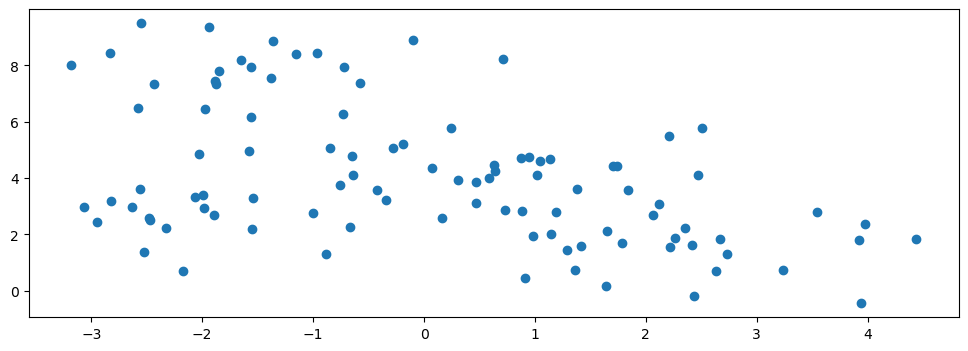

In [9]:
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]

# generate 150 random points
np.random.seed(0)
X_all, y_all = datasets.make_blobs(150, centers=4)

# use the first 100 points as the main dataset
X, y = X_all[:100], y_all[:100]
plt.scatter(X[:,0], X[:,1])

We know the true labels of these clusers, and we can visualize them.

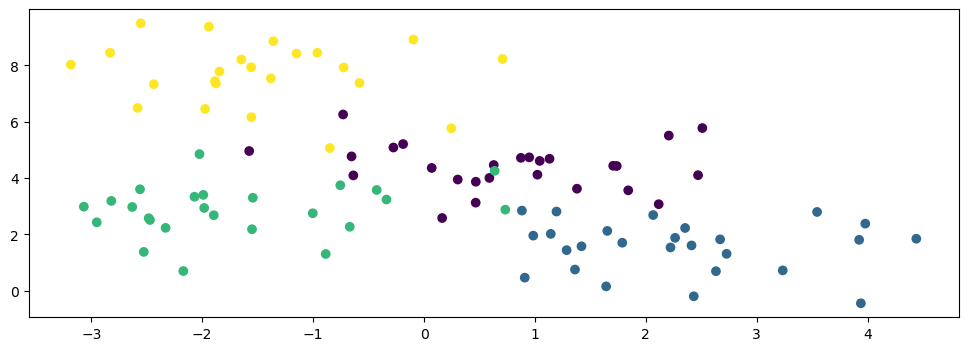

In [10]:
plt.scatter(X[:,0], X[:,1], c=y)

We will also keep 50 points as a holdout set.

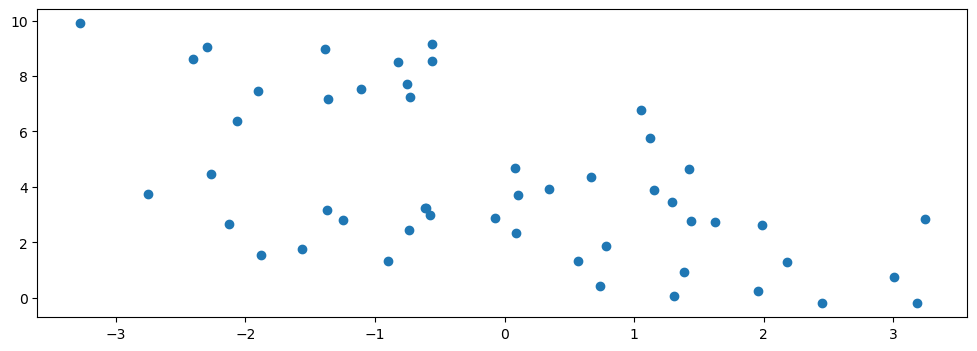

In [11]:
# use the last 50 points as a holdout set
X_holdout, y_holdout = X_all[100:], y_all[100:]
plt.scatter(X_holdout[:,0], X_holdout[:,1])

# Underfitting in Unsupervised Learning

Underfitting happens when we are not able to fully learn the signal hidden in the data.

In the context of GMMs, this means not capturing all the clusters in the data.

Let's fit a GMM on our toy dataset.

In [12]:
# fit a GMM
from sklearn import mixture
model = mixture.GaussianMixture(n_components=2)
model.fit(X)

GaussianMixture(n_components=2)

The model finds two distinct components in the data, but they fail to capture the true structure.

We can also measure the value of our objective (the log-likelihood) on the training and holdout sets.

Training Set Log-Likelihood (higher is better): -4.08
Holdout Set Log-Likelihood (higher is better): -4.07


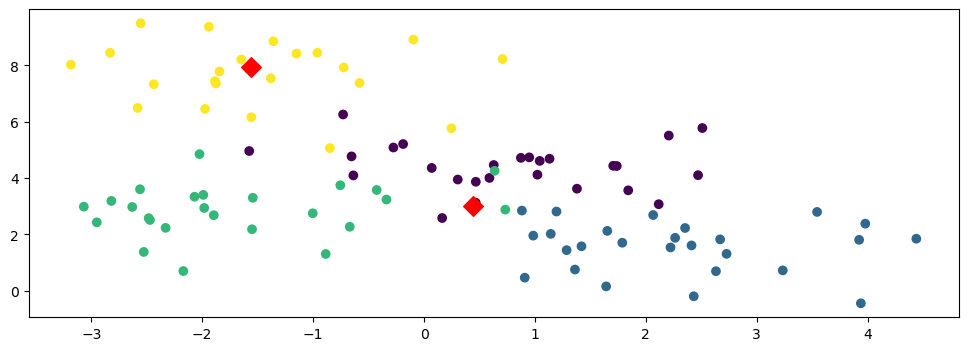

In [13]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(model.means_[:,0], model.means_[:,1], marker='D', c='r', s=100)
print('Training Set Log-Likelihood (higher is better): %.2f' % model.score(X))
print('Holdout Set Log-Likelihood (higher is better): %.2f' % model.score(X_holdout))

Consider now what happens if we further increase the number of clusters.

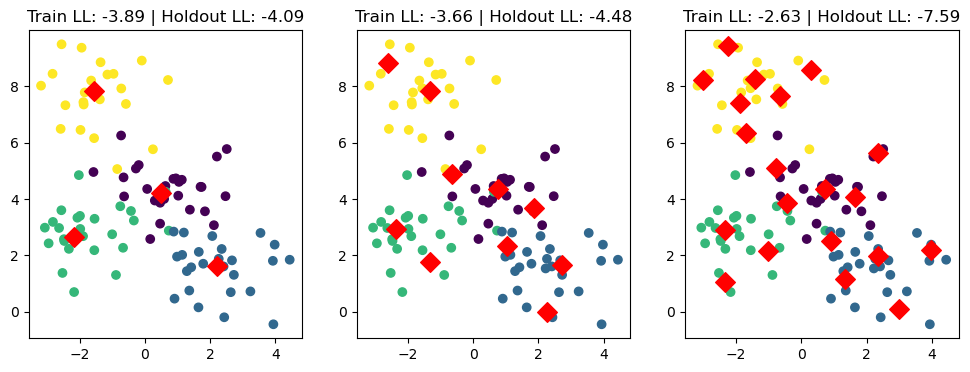

In [14]:
Ks = [4, 10, 20]
f, axes = plt.subplots(1,3)
for k, ax in zip(Ks, axes):
    model = mixture.GaussianMixture(n_components=k)
    model.fit(X)
    ax.scatter(X[:,0], X[:,1], c=y)
    ax.scatter(model.means_[:,0], model.means_[:,1], marker='D', c='r', s=100)
    ax.set_title('Train LL: %.2f | Holdout LL: %.2f' % (model.score(X), model.score(X_holdout)))

# Overfitting in Unsupervised Learning

Overfitting happens when we fit the noise, but not the signal.

In our example, this means fitting small, local noise clusters rather than the true global clusters.

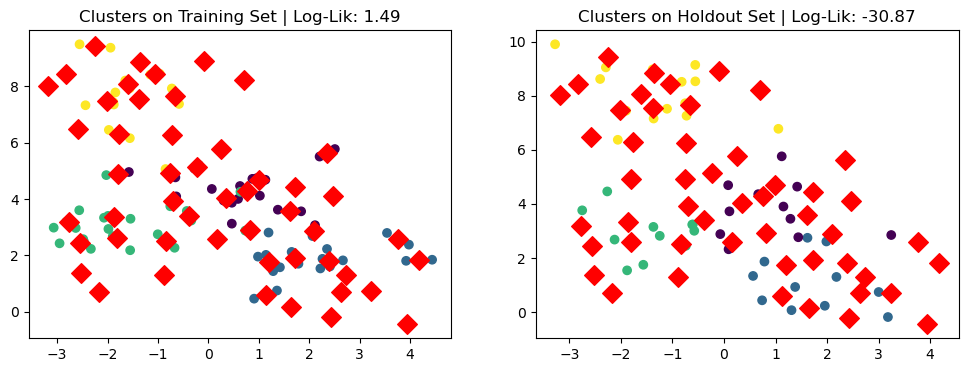

In [15]:
model = mixture.GaussianMixture(n_components=50)
model.fit(X)

plt.subplot(121)
plt.title('Clusters on Training Set | Log-Lik: %.2f' % model.score(X))
plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(model.means_[:,0], model.means_[:,1], marker='D', c='r', s=100)

plt.subplot(122)
plt.title('Clusters on Holdout Set | Log-Lik: %.2f' % model.score(X_holdout))
plt.scatter(X_holdout[:,0], X_holdout[:,1], c=y_holdout)
plt.scatter(model.means_[:,0], model.means_[:,1], marker='D', c='r', s=100)

# Measuring Generalization Using Log-Likelihood

Probabilistic unsupervised models optimize an objective that can be used to detect overfitting and underfitting by comparing performance between training and holdout sets.

Below, we visualize the performance (measured via negative log-likelihood) on training and holdout sets as $K$ increases.

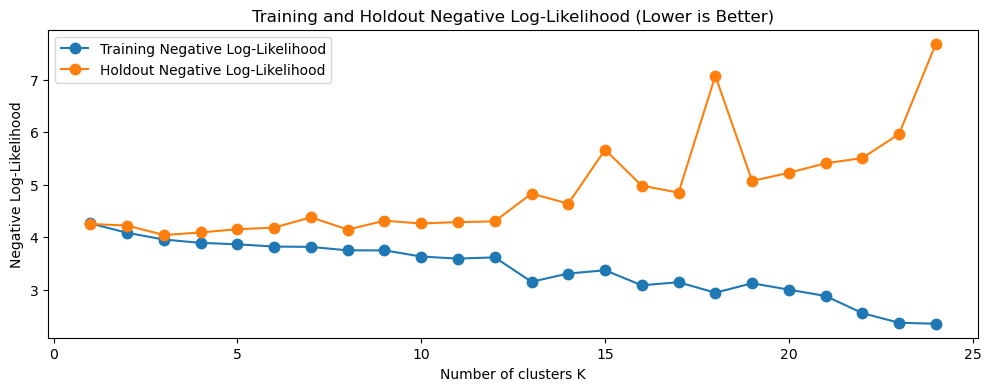

In [16]:
Ks, training_objs, holdout_objs = range(1,25), [], []
for k in Ks:
    model = mixture.GaussianMixture(n_components=k)
    model.fit(X)
    training_objs.append(-model.score(X))
    holdout_objs.append(-model.score(X_holdout))

plt.plot(Ks, training_objs, '.-', markersize=15)
plt.plot(Ks, holdout_objs, '.-', markersize=15)
plt.xlabel("Number of clusters K")
plt.ylabel("Negative Log-Likelihood")
plt.title("Training and Holdout Negative Log-Likelihood (Lower is Better)")
plt.legend(['Training Negative Log-Likelihood', 'Holdout Negative Log-Likelihood'])

__Warning__: This process doesn't work as well as in supervised learning

For example, detecting overfitting with larger datasets will be paradoxically harder (try it!)

# Summary

* We can reduce clustering to fitting a GMM with latent $z$
* A GMM can be fit without labels via EM: we alternate between hallucinating labels and optimizing the model.
* A probabilistic model can detect overfitting by comparing the likelihood of training data vs. that of holdout data.